In [1]:
import pandas as pd
import numpy as np

Я заниюмаюсь управлением товародвижения в федеральной сети ювелирных магазинов (900 магазинов). Отвечаю за изделия из золота. В данной работе хочу применить машинное обучение для:

- прогноза продаж ассортимента определенного типа для каждого торгового объекта(магазина) в отдельности
- выявление главных признаков торгового объекта(магазина), котороые влияют на продажи ассортимента определенного типа

Делать это буду на примере мусульманских подвесов.
Для анализа буду использовать данные по продажам мусульманских подвесов из серебра, т.к. они присутствуют почти в каждом магазине.
Практическая польза

In [2]:
# Загружаю датасет с продажами серебра и золота 
name = r'C:\нетология\muslim.xlsx'
mus_sales = pd.read_excel(name, sheet_name='олап', skiprows=10, usecols=[0,2,3], names=['id','585_msale','925_msale'])

# Убираем пустые значения после 'Общий итог'
lst = mus_sales['id'].tolist()
mus_sales = mus_sales.drop(axis=0,index=np.arange(lst.index('Общий итог'),len(lst)))
mus_sales.tail()

,id,585_msale,925_msale
893,92,0.0,1.0
894,925,0.0,2.0
895,955,1.0,8.0
896,96,7.0,13.0
897,99,12.0,14.0


In [3]:
name = r'C:\нетология\muslim.xlsx'
mus_stock = pd.read_excel(name, sheet_name='олап', skiprows=10, usecols=[7,9,10],names=['id','585_mstock','925_mstock'])

# Убираем пустые значения
lst = mus_stock['id'].tolist()
mus_stock = mus_stock.drop(axis=0,index=np.arange(lst.index('Общий итог'),len(lst)))

# Убираем магазины с нулевыми остатками
mus_stock['sum'] = mus_stock['585_mstock'] + mus_stock['925_mstock']
mus_stock = mus_stock[(mus_stock['sum'] > 0)]
del mus_stock['sum']
mus_stock.tail()

,id,585_mstock,925_mstock
1462,92,26.0,8.0
1463,925,1.0,11.0
1464,955,5.0,10.0
1465,96,22.0,14.0
1468,99,27.0,20.0


In [4]:
# Оставляем склады, где есть остатки золото и серебро одновременно

mus_stock_combined = mus_stock[(mus_stock['585_mstock'] > 5)&(mus_stock['925_mstock'] > 5)].drop(axis=1, labels=['585_mstock','925_mstock'])

# Посмотрим корреляцию в продажах золота и серебра
mus_sales_combined = pd.merge(mus_stock_combined, mus_sales, on='id',how='left').dropna(how='any')
mus_sales_combined[['585_msale','925_msale']].corr().round(decimals=1)

,585_msale,925_msale
585_msale,1.0,0.7
925_msale,0.7,1.0


Коэффицент корреляции между золотом и серебром 0,7. Можно использовать данные по серебру

In [5]:
# Посмотрим есть ли разница в распределении продаж по золоту и серебру
mus_sales_combined.describe().round()

,585_msale,925_msale
count,492.0,492.0
mean,10.0,12.0
std,10.0,12.0
min,0.0,0.0
25%,3.0,5.0
50%,7.0,9.0
75%,14.0,15.0
max,57.0,82.0


Вопросы: 
- нужно ли объединять тц и трц?
- разные размерности и порядок исчисления (продажи и емкость магазина в штуках, зарплата в рублях, доли в процентах)


###### Создаем большой датасет для обучения модели со следующей информацией:

+ id - номер магазина его перед обучением я удалю
+ 925_msale - продажи мусульманских подвесов - целевая переменная
+ type - тип размещения объекта (отдельное здание или торговый центр)
+ city - город или населенный пункт, по этому параметру каждому объекту можно установить признак региона
+ shop_size - вместимость объекта в штуках
+ work_time - время работы объекта в годах 
+ total_sales - общие продажи в штуках за полгода
+ brand - вывеска на магазине(есть несколько брэндов)
+ population - количество жителей в данном населенном пункте 
+ salary - средняя зарплата (distr - в округе,reg - в регионе)
+ mosque - есть или нет в населенном пункте мечеть(по данным из википедии)
+ muslim_per - процент верующих мусульман (distr - в округе,reg - в регионе)
+ rus_per - процент русских по национальности (distr - в округе,reg - в регионе)
+ religion_imp - процент людей, для которых религия играет важную роль в жизни (distr - в округе,reg - в регионе)


###### Откуда брал данные:

+ Численность населения - Оценка численности постоянного населения на 1 января 2018г.Росстат по городам
+ Доля мусульман, процент русских, процент религиозных - Общероссийский опрос МегаФОМ 29 мая – 25 июня 2012 г. по субъектам РФ
+ Доходы населения - Среднемесячная номинальная начисленная заработная плата работников по полному кругу организаций  по субъектам Российской Федерации. Росстат. 2018-2019 г
+ Количество мечетей - википедия статья Ислам в России
+ Данные по долготе/широте/региону получал через GeoPy по городу


Все данные собрал в единую таблицу в EXcel потом загрузил в ноутбук.

Чеченская  и Ингушская республика не участвовала в исследовании МегаФОМ. Поэтому для этих республик инфу пришлось искать отдельно

In [7]:
# Загружаем справочник с характеристиками магазинов и дополнительной информацией по регионам. 
ref_book = pd.read_excel(r'C:\нетология\muslim.xlsx', sheet_name='типы', usecols=list(range(6,27)))
ref_book['id'] = ref_book['id'].astype(str)
ref_book.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 21 columns):
id                    903 non-null object
city                  903 non-null object
type                  903 non-null object
shop_size             900 non-null float64
work_time             903 non-null int64
total_sales           899 non-null float64
stock_month           903 non-null int64
brand                 903 non-null object
population            898 non-null float64
salary_reg            898 non-null float64
salary_district       898 non-null float64
mosque                903 non-null int64
muslim_per_reg        898 non-null float64
muslim_per_distr      898 non-null float64
religion_imp_reg      898 non-null float64
religion_imp_distr    898 non-null float64
rus_per_reg           898 non-null float64
rus_per_distr         898 non-null float64
coord                 898 non-null object
district              898 non-null object
region                898 non-null object
dtype

In [8]:
# Добавляем к продажам подвесов по магазинам всю информацию из справочника

raw_df = pd.merge(mus_sales[['id','925_msale']],ref_book,how='left', on='id')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 899
Data columns (total 22 columns):
id                    900 non-null object
925_msale             900 non-null float64
city                  876 non-null object
type                  876 non-null object
shop_size             876 non-null float64
work_time             876 non-null float64
total_sales           876 non-null float64
stock_month           876 non-null float64
brand                 876 non-null object
population            871 non-null float64
salary_reg            871 non-null float64
salary_district       871 non-null float64
mosque                876 non-null float64
muslim_per_reg        871 non-null float64
muslim_per_distr      871 non-null float64
religion_imp_reg      871 non-null float64
religion_imp_distr    871 non-null float64
rus_per_reg           871 non-null float64
rus_per_distr         871 non-null float64
coord                 871 non-null object
district              871 non-null objec

In [9]:
# Округлим размер и уберем маги, которые работают меньше 4 месяцев 
raw_df['shop_size'] = raw_df['shop_size'].round()
raw_df = raw_df[raw_df['stock_month'] > 4]

In [10]:
# Уберем франчайзинговые магазины - там перекос по ассортименту

raw_df = raw_df[raw_df['type']!='франч']
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845 entries, 0 to 899
Data columns (total 22 columns):
id                    845 non-null object
925_msale             845 non-null float64
city                  845 non-null object
type                  845 non-null object
shop_size             845 non-null float64
work_time             845 non-null float64
total_sales           845 non-null float64
stock_month           845 non-null float64
brand                 845 non-null object
population            845 non-null float64
salary_reg            845 non-null float64
salary_district       845 non-null float64
mosque                845 non-null float64
muslim_per_reg        845 non-null float64
muslim_per_distr      845 non-null float64
religion_imp_reg      845 non-null float64
religion_imp_distr    845 non-null float64
rus_per_reg           845 non-null float64
rus_per_distr         845 non-null float64
coord                 845 non-null object
district              845 non-null objec

In [11]:
# Уберем магазины со спец ассортиментом, там больше нет мусульманских подвесов
raw_df.where(raw_df.brand != 0, inplace=True)
# Удаляем строки без значений
raw_df.dropna(how='all', inplace=True)

In [12]:
# Корреляция количественных признаков с целевым значением
corr_matrix = raw_df.corr().round(decimals=2)
corr_matrix['925_msale'].sort_values(ascending=False)

925_msale             1.00
muslim_per_reg        0.51
total_sales           0.41
religion_imp_reg      0.38
mosque                0.22
muslim_per_distr      0.20
religion_imp_distr    0.18
shop_size             0.17
salary_reg            0.13
population            0.09
stock_month           0.03
salary_district      -0.14
work_time            -0.14
rus_per_distr        -0.25
rus_per_reg          -0.47
Name: 925_msale, dtype: float64

In [13]:
# Разделим датафрейм на два, в одном будут собраны региональные признаки, в другом признаки по округам 
# возможно какой то датасет даст более точный результат

drop_distr = [x for x in raw_df.columns.tolist() if '_reg' in x] + ['id','stock_month','coord','region']
drop_reg = [x for x in raw_df.columns.tolist() if '_distr'in x] + ['id','stock_month','coord']

distr_df = raw_df.drop(drop_distr, axis=1)
reg_df = raw_df.drop(drop_reg, axis=1)

In [14]:
distr_df.head()

,925_msale,city,type,shop_size,work_time,total_sales,brand,population,salary_district,mosque,muslim_per_distr,religion_imp_distr,rus_per_distr,district
0,7.0,Астрахань,Стрит,4809.0,12.0,465.0,ab,533925.0,32501.94,1.0,2.937507,12.754090,87.367898,ЮФО
1,12.0,Белгород,Стрит,13135.0,12.0,1899.0,a,391554.0,58083.38,0.0,1.587594,15.818874,93.793375,ЦФО
2,6.0,Ставрополь,Стрит,5378.0,8.0,917.0,a,433931.0,27505.38,0.0,40.394395,29.797887,38.837755,СКФО
3,9.0,Выборг,Стрит,13141.0,8.0,2904.0,b,77400.0,50754.60,0.0,1.059460,13.374155,90.223258,СЗФО
4,13.0,Энгельс,Стрит,7831.0,12.0,1779.0,a,226176.0,32783.10,0.0,12.317776,16.559501,68.107610,ПФО


In [139]:
# проверим сбалансированность категориальных данных
category = ['city','type','brand', 'district',  'region']            
(raw_df['city'].value_counts(normalize=True)*100).round()

Санкт-Петербург      5.0
Новосибирск          3.0
Ростов-на-Дону       3.0
Екатеринбург         2.0
Красноярск           2.0
Краснодар            2.0
Тюмень               2.0
Уфа                  2.0
Сочи                 1.0
Челябинск            1.0
Саратов              1.0
Омск                 1.0
Сургут               1.0
Новокузнецк          1.0
Москва               1.0
Воронеж              1.0
Волгоград            1.0
Казань               1.0
Ставрополь           1.0
Астрахань            1.0
Барнаул              1.0
Улан-Удэ             1.0
Иркутск              1.0
Курган               1.0
Пермь                1.0
Орел                 1.0
Томск                1.0
Самара               1.0
Мурманск             1.0
Владикавказ          1.0
                    ... 
Слободской           0.0
Ржев                 0.0
Пыть-Ях              0.0
Черемхово            0.0
Назрань              0.0
Приморско-Ахтарск    0.0
Южно-Сахалинск       0.0
Сухой Лог            0.0
Борисоглебск         0.0


In [140]:
(raw_df['type'].value_counts(normalize=True)*100).round()

Стрит    58.0
ТЦ       20.0
ТРЦ      19.0
ГМ        3.0
Рынок     0.0
Name: type, dtype: float64

In [141]:
(raw_df['brand'].value_counts(normalize=True)*100).round()

a         35.0
b         34.0
ab        29.0
silver     2.0
Name: brand, dtype: float64

In [142]:
(raw_df['district'].value_counts(normalize=True)*100).round()

ЮФО     18.0
СФО     17.0
УФО     15.0
ЦФО     14.0
ПФО     14.0
СЗФО    12.0
СКФО     7.0
ДФО      3.0
Name: district, dtype: float64

In [143]:
(raw_df['region'].value_counts(normalize=True)*100).round()

Краснодарский край                   8.0
Ростовская область                   6.0
г.Санкт-Петербург                    5.0
Свердловская область                 4.0
Ханты-Мансийский автономный округ    4.0
Красноярский край                    4.0
Новосибирская область                3.0
Кемеровская область                  3.0
Ставропольский край                  3.0
Московская область                   3.0
Саратовская область                  2.0
Волгоградская область                2.0
Республика Башкортостан              2.0
Тюменская область                    2.0
Челябинская область                  2.0
Республика Татарстан                 2.0
Алтайский край                       2.0
Пермский край                        2.0
Иркутская область                    2.0
Воронежская область                  1.0
Мурманская область                   1.0
Ямало-Ненецкий автономный округ      1.0
Омская область                       1.0
Архангельская область                1.0
Нижегородская об

In [144]:
raw_df[category].nunique()

city        344
type          5
brand         4
district      8
region       79
dtype: int64

In [145]:
# проверим нормальность распределения числовых данных
numeric = [x for x in raw_df.columns.to_list() if x not in category][1:-1]
numeric.remove('stock_month')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A400B47208>,
      dtype=object)

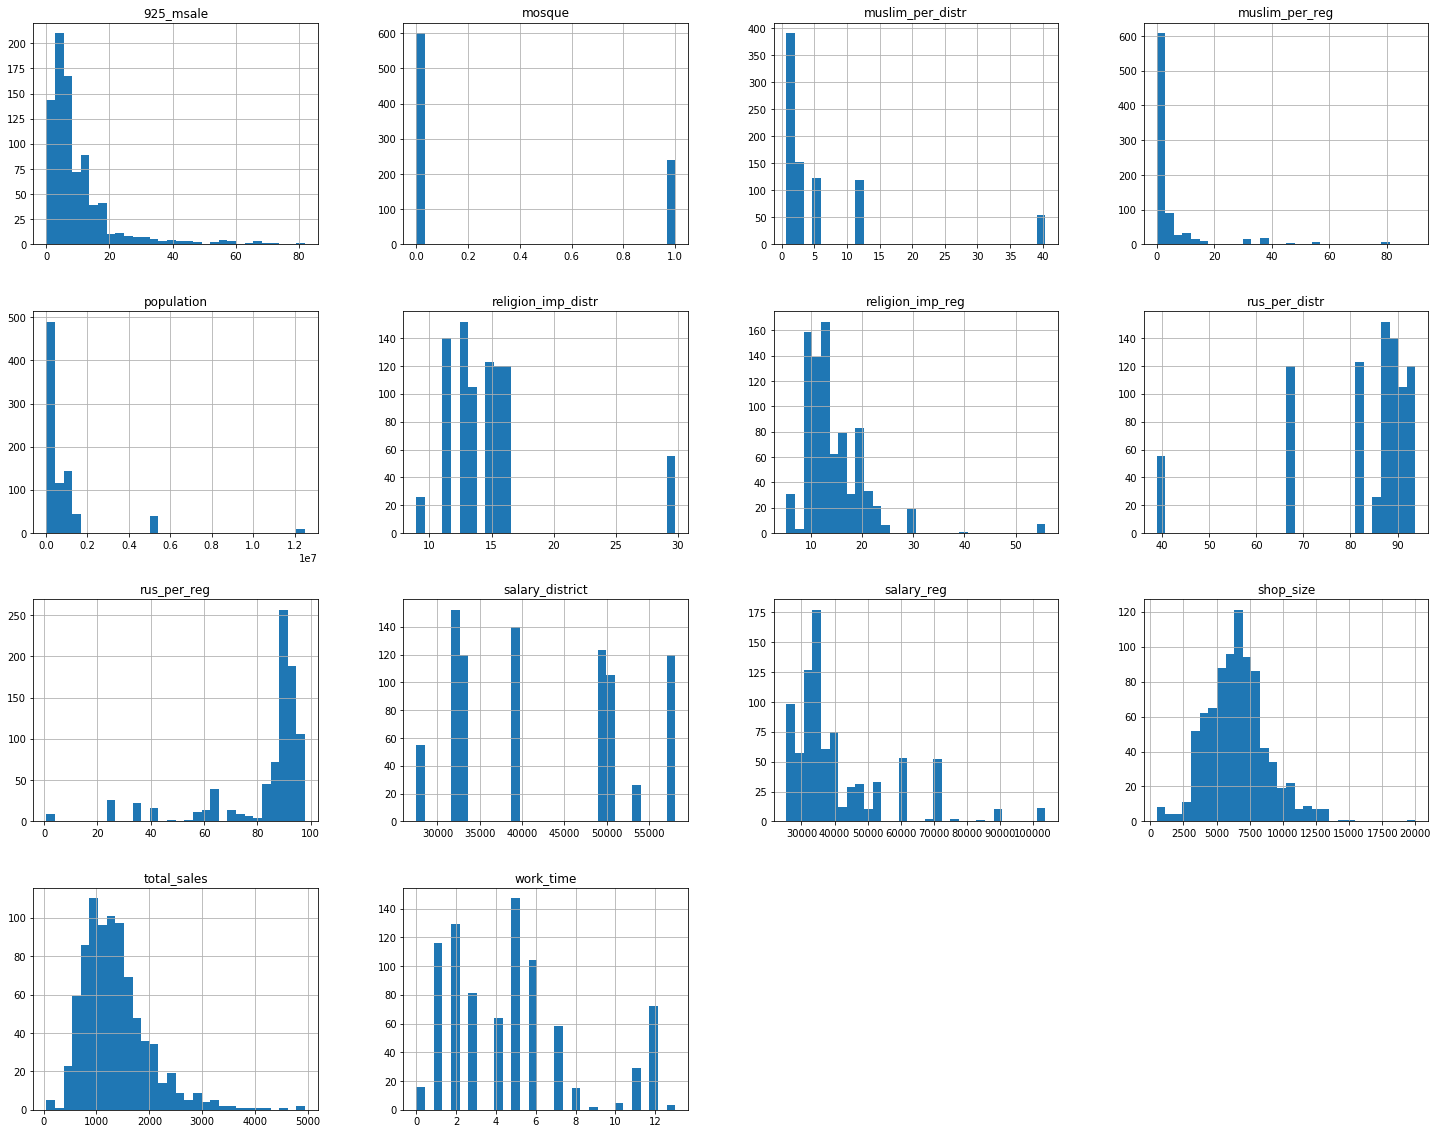

In [146]:
raw_df[numeric].hist(bins=30, figsize=(25,20))

In [15]:
#датасет с убранными для обучения столбцами
new_df = raw_df.drop(['city', 'region'] + drop_reg, axis=1)

In [16]:
# конвертируем все значения в int32
category_list = ['type', 'brand','district']
numeric_list = [x for x in new_df.columns.to_list() if x not in category_list]
new_df[numeric_list] = new_df[numeric_list].astype('float32')

In [18]:
# проверяем данные на нули и меняем нули если нужно

pd.get_dummies(new_df,dtype='float32').drop(['925_msale'],axis=1).isnull().values.any()

False

In [19]:
train_df = pd.get_dummies(new_df,dtype='float32')
train_df.rename(columns={'925_msale':'msale'},inplace=True)

###### Выводы после анализа категориальных и числовых признаков

Сначала была идея разделить датасет на два: один с  региональными признаками, другой с признаками по округам чтобы посмотреть какой датасет даст более точный результат. Проанализировав категориальные и числовые признаки я отклонил эту идею. Количественные признаки нужно брать с привязкой к региону, а категориальный признак **регион** придется убрать - почти все регионы занимают меньше 1% по количеству в выборке при этом есть числовые признаки, привязанные к ним. Также уберу признак **город**.  
**Доходы, время работы** разобью на группы, которые переведу вместе с категориальными признаками в бинарные.  
**Переменные в процентах переведу в проценты**-?
**Размер магазина и общие продажи** нормализую -?  
**Выберу 3 модели регрессии и покручу данные с замеркой точности перед этим проведу анализ фичей при помощи РСА**

In [120]:
# обучаю разные модели регрессий
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, BayesianRidge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

X = train_df.drop(['msale'],axis=1)
y = train_df['msale']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# создаю объекты
lm = LinearRegression()
rg = Ridge(alpha=1000)
ls = Lasso()
bs = BayesianRidge()
lr = LogisticRegression()

# тренирую модели
lm.fit(X_train, y_train)
rg.fit(X_train, y_train)
ls.fit(X_train, y_train)
bs.fit(X_train, y_train)
lr.fit(X_train, y_train)

#создаю предсказания
lm_y_pred = lm.predict(X_test)
rg_y_pred = rg.predict(X_test)
ls_y_pred = ls.predict(X_test)
bs_y_pred = bs.predict(X_test)
lr_y_pred = lr.predict(X_test)



In [121]:
#Метрики
print('Linear Regression R^2: %.2f' % r2_score(y_test, lm_y_pred))
print("Linear Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, lm_y_pred))

print('Ridge Regression R^2: %.2f' % r2_score(y_test, rg_y_pred))
print("Ridge Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, rg_y_pred))

print('Lasso Regression R^2: %.2f' % r2_score(y_test, ls_y_pred))
print("Lasso Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, ls_y_pred))

print('Bayesian Ridge Regression R^2: %.2f' % r2_score(y_test, bs_y_pred))
print("Bayesian Ridge Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, bs_y_pred))

print('Logistic Regression R^2: %.2f' % r2_score(y_test, lr_y_pred))
print("Logistic Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, lr_y_pred))


Linear Regression R^2: 0.65
Linear Regression Средний квадрат ошибки: 47.20
Ridge Regression R^2: 0.61
Ridge Regression Средний квадрат ошибки: 52.48
Lasso Regression R^2: 0.58
Lasso Regression Средний квадрат ошибки: 55.64
Bayesian Ridge Regression R^2: 0.66
Bayesian Ridge Regression Средний квадрат ошибки: 45.50
Logistic Regression R^2: -0.15
Logistic Regression Средний квадрат ошибки: 154.14


In [28]:
y_test.describe()

count    169.000000
mean       8.307693
std        7.749809
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       41.000000
Name: msale, dtype: float64

In [29]:
y_train.describe()

count    672.000000
mean       9.967262
std       11.327483
min        0.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       82.000000
Name: msale, dtype: float64

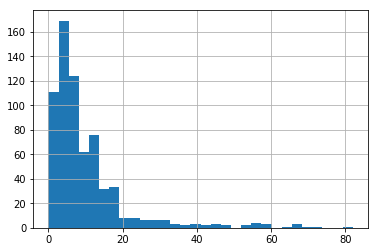

In [30]:
y_train.hist(bins=30)


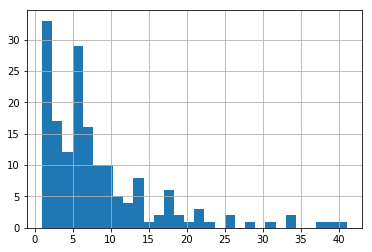

In [31]:
y_test.hist(bins=30)

In [32]:
def get_formula(columns):
    return 'msale ~ ' + " + ".join(columns)
col_list = train_df.columns.drop('msale')


In [124]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

est = smf.ols(get_formula(col_list),data=train_df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  msale   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     51.07
Date:                Thu, 03 Oct 2019   Prob (F-statistic):          8.34e-141
Time:                        09:38:55   Log-Likelihood:                -2813.2
No. Observations:                 841   AIC:                             5674.
Df Residuals:                     817   BIC:                             5788.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.3345      1.984      0.672      0.501      -2.561       5.230
shop_size         3.272e-05      0.000      0.208      0.835      -0.000       0.000
work_time           -0.0552      0.105     -0.526      0.599      -0.261       0.151
total_sales          0.0071      0.001     13.311      0.000       0.006       0.008
population        5.305e-08   2.05e-07      0.258      0.796    -3.5e-07    4.56e-07
salary_reg        8.212e-05   2.48e-05      3.317      0.001    3.35e-05       0.000
mosque               1.1049      0.685      1.614      0.107      -0.239       2.449
muslim_per_reg       0.3782      0.044      8.683      0.000       0.293       0.464
religion_imp_reg    -0.0070      0.067     -0.103      0.918      -0.139       0.125
rus_per_reg         -0.0704      0.025     -2.821      0.005      -0.119      -0.021
type_ГМ             -1.3177      1.494     -0.882      0.378      -4.250       1.614
type_Рынок           4.7434      4.153      1.142      0.254      -3.408      12.895
type_Стрит          -1.7476      1.032     -1.694      0.091      -3.773       0.278
type_ТРЦ             0.5081      1.095      0.464      0.643      -1.641       2.657
type_ТЦ             -0.8516      1.078     -0.790      0.430      -2.968       1.265
brand_a             -1.4291      0.846     -1.689      0.092      -3.089       0.231
brand_ab            -1.6631      0.813     -2.045      0.041      -3.259      -0.067
brand_b             -0.0190      0.775     -0.025      0.980      -1.540       1.502
brand_silver         4.4457      1.725      2.577      0.010       1.059       7.832
district_ДФО        -1.8665      1.296     -1.440      0.150      -4.411       0.678
district_ПФО         6.6589      0.716      9.306      0.000       5.254       8.063
district_СЗФО       -1.9569      0.996     -1.966      0.050      -3.911      -0.003
district_СКФО       -4.3413      1.112     -3.905      0.000      -6.523      -2.159
district_СФО        -0.2147      0.711     -0.302      0.763      -1.610       1.180
district_УФО         1.0223      0.902      1.133      0.257      -0.748       2.793
district_ЦФО         1.3672      0.856      1.597      0.111      -0.314       3.048
district_ЮФО         0.6656      0.679      0.980      0.327      -0.667       1.998
==============================================================================
Omnibus:                      282.552   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1878.778
Skew:                           1.358   Prob(JB):                         0.00
Kurtosis:                       9.800   Cond. No.                     1.07e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance m

Обучу модели вернув обратно название региона

In [20]:
train_df1 = raw_df.drop(['id','city','coord'], axis=1)
train_df1 = pd.get_dummies(train_df1)
train_df1.rename(columns={'925_msale':'msale'},inplace=True)

In [92]:
# обучаю разные модели регрессий
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, BayesianRidge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

X = train_df1.drop(['msale'],axis=1)
y = train_df1['msale']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# создаю объекты
lm = LinearRegression()
rg = Ridge(alpha=1)
ls = Lasso(alpha=1)
bs = BayesianRidge()
lr = LogisticRegression()

# тренирую модели
lm.fit(X_train, y_train)
rg.fit(X_train, y_train)
ls.fit(X_train, y_train)
bs.fit(X_train, y_train)
lr.fit(X_train, y_train)

#создаю предсказания
lm_y_pred = lm.predict(X_test)
rg_y_pred = rg.predict(X_test)
ls_y_pred = ls.predict(X_test)
bs_y_pred = bs.predict(X_test)
lr_y_pred = lr.predict(X_test)


In [93]:
#Метрики
print('Linear Regression R^2: %.2f' % r2_score(y_test, lm_y_pred))
print("Linear Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, lm_y_pred))

print('Ridge Regression R^2: %.2f' % r2_score(y_test, rg_y_pred))
print("Ridge Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, rg_y_pred))

print('Lasso Regression R^2: %.2f' % r2_score(y_test, ls_y_pred))
print("Lasso Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, ls_y_pred))

print('Bayesian Ridge Regression R^2: %.2f' % r2_score(y_test, bs_y_pred))
print("Bayesian Ridge Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, bs_y_pred))

print('Logistic Regression R^2: %.2f' % r2_score(y_test, lr_y_pred))
print("Logistic Regression Средний квадрат ошибки: %.2f" % mean_squared_error(y_test, lr_y_pred))

Linear Regression R^2: 0.71
Linear Regression Средний квадрат ошибки: 40.09
Ridge Regression R^2: 0.71
Ridge Regression Средний квадрат ошибки: 39.92
Lasso Regression R^2: 0.46
Lasso Regression Средний квадрат ошибки: 73.43
Bayesian Ridge Regression R^2: 0.71
Bayesian Ridge Regression Средний квадрат ошибки: 40.36
Logistic Regression R^2: -0.03
Logistic Regression Средний квадрат ошибки: 140.82


In [ ]:

scaler = StandardScaler()
pca = PCA().fit(scaler.fit_transform(X))
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

Преобразую целевую переменную из числовой в категориальную

In [156]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 899
Columns: 111 entries, msale to region_г.Санкт-Петербург
dtypes: float64(15), uint8(96)
memory usage: 184.0 KB


In [157]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 899
Data columns (total 27 columns):
msale               841 non-null float32
shop_size           841 non-null float32
work_time           841 non-null float32
total_sales         841 non-null float32
population          841 non-null float32
salary_reg          841 non-null float32
mosque              841 non-null float32
muslim_per_reg      841 non-null float32
religion_imp_reg    841 non-null float32
rus_per_reg         841 non-null float32
type_ГМ             841 non-null float32
type_Рынок          841 non-null float32
type_Стрит          841 non-null float32
type_ТРЦ            841 non-null float32
type_ТЦ             841 non-null float32
brand_a             841 non-null float32
brand_ab            841 non-null float32
brand_b             841 non-null float32
brand_silver        841 non-null float32
district_ДФО        841 non-null float32
district_ПФО        841 non-null float32
district_СЗФО       841 non-null f

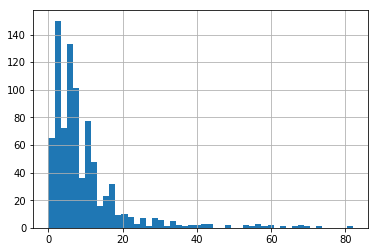

In [168]:
train_df['msale'].hist(bins=50)

In [165]:
train_df['msale'].describe()

count    841.000000
mean       9.633769
std       10.721536
min        0.000000
25%        3.000000
50%        7.000000
75%       11.000000
max       82.000000
Name: msale, dtype: float64

In [175]:
pd.qcut(train_df['msale'],3,labels=['bad','medium','good']).value_counts()

medium    306
bad       287
good      248
Name: msale, dtype: int64

In [25]:
# прогноз по классам без регионов
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score
X = train_df.drop(['msale'],axis=1)
y = pd.qcut(train_df['msale'],3,labels=['bad','medium','good'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [26]:
y


0      medium
1        good
2      medium
3      medium
4        good
5        good
6      medium
7      medium
8      medium
9        good
10     medium
11        bad
12     medium
13     medium
14        bad
15        bad
16     medium
17        bad
18       good
19        bad
20     medium
21        bad
22       good
23       good
24       good
25        bad
26        bad
27        bad
28       good
29        bad
        ...  
870       bad
871      good
872    medium
873    medium
874      good
875      good
876    medium
877    medium
878      good
879      good
880       bad
881    medium
882    medium
883    medium
884      good
885      good
886    medium
887    medium
888    medium
889    medium
890    medium
891       bad
892       bad
893      good
894    medium
895       bad
896       bad
897    medium
898      good
899      good
Name: msale, Length: 841, dtype: category
Categories (3, object): [bad < medium < good]

In [28]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_train_predict = clf.predict_proba(X_train)
y_train_predict

array([[0.1, 0.9, 0. ],
       [0. , 1. , 0. ],
       [0.2, 0.7, 0.1],
       ...,
       [0. , 0.2, 0.8],
       [0.8, 0. , 0.2],
       [0.9, 0. , 0.1]])

In [29]:
y_train

483      good
328      good
392      good
802    medium
45       good
874      good
199      good
648    medium
371       bad
566      good
541    medium
195       bad
820    medium
203      good
897    medium
808      good
141      good
692      good
114       bad
78     medium
91       good
212       bad
44        bad
892       bad
61     medium
182      good
211    medium
618    medium
396       bad
240      good
        ...  
737       bad
242       bad
452       bad
409    medium
122    medium
564      good
684    medium
801       bad
881    medium
447    medium
542       bad
428       bad
539      good
498    medium
809      good
813    medium
302    medium
393    medium
112    medium
706    medium
488      good
126       bad
834    medium
460    medium
505    medium
611       bad
567       bad
304    medium
15        bad
735       bad
Name: msale, Length: 672, dtype: category
Categories (3, object): [bad < medium < good]

In [27]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_train_predict = clf.predict_proba(X_train)
y_test_predict = clf.predict_proba(X_test)

print(precision_score(y_train, y_train_predict))
print(precision_score(y_test, y_test_predict))

print(accuracy_score(y_train, y_train_predict))
print(accuracy_score(y_test, y_test_predict))


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [ ]:
# прогноз по классам с регионами

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score
X = train_df1.drop(['msale'],axis=1)
y = pd.qcut(train_df1['msale'],3,labels=['bad','medium','good'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_train_predict = clf.predict_proba(X_train)
y_test_predict = clf.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_predict))
print(roc_auc_score(y_test, y_test_predict))

print(precision_score(y_train, y_train_predict))
print(precision_score(y_test, y_test_predict))

print(accuracy_score(y_train, y_train_predict))
print(accuracy_score(y_test, y_test_predict))
